# Developing a first-order algorithm to construct a portfolio using Intraday data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### $\bold{Problem \ Statement}$

#### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.

#### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
#### We assume that on each day, a position is taken at the open, and closed at noon. So we define:

$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.

####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 

#### There are no constraints on the quantities $x_j$.

##### The first sum is negative of the average return earned by the portfolio. In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$. The quantity $\theta$ is a risk aversion parameter.
 

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### 
#### Your method should work with values of $T$ at least $100$.
#### Use the data provided for AMZN, NFLX, TSLA, i.e., $n = 3$. 
###
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

#### Computing the function value:

$$ \text{f = }  \left(-\sum_{j = 1}^{n=3} \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^{n=3} (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$

In [61]:
def evalFun(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2):
    # quantity 1
    q1 = - ( r0*x0 + r1*x1 + r2*x2 )

    # quantity 2
    temp = ( (( (rt0 - r0) * x0 ) + ( (rt1 - r1) * x1 ) + ( (rt2 - r2) * x2 ))**pi )
    q2 = theta * ( (np.sum(temp) / T ) ** (1/pi) )

    return q1 + q2

#### Computing the function gradient:

$$ \text{$f_j\ '$} = \ \left(- \bar r_j \right) \ 
                                                +
                                                \
                                                \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t}-\bar r_j) x_j\right]^\pi\right)^{(1-\pi)/\pi} \ 
                                                \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t}-\bar r_j) x_j\right]^{\pi-1}\right) \ 
                                                \left(r_{j,t} - \bar r_j\right)
                                                $$

####

$$ \text{$f_j\ '$} = \ \left(- \bar r_j \right) \ 
                                                +
                                                \
                                                \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n n_{j,t} \ x_j\right]^\pi\right)^{(1-\pi)/\pi} \ 
                                                \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n n_{j,t} \ x_j\right]^{\pi-1}\right) \ 
                                                \left(n_{j,t}\right)
                                                $$



In [266]:
def evalGrad(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2):

    # quantity 1 derivative w.r.t x0, x1, x2
    q1_0 = - r0
    q1_1 = - r1
    q1_2 = - r2

    # quantity 2 derivative w.r.t x0, x1, x2
    nt0 = rt0 - r0
    nt1 = rt1 - r1
    nt2 = rt2 - r2

    mt = ( (nt0 * x0 ) + (nt1 * x1 ) + (nt2 * x2 ))

    q2_common = (theta/(T**(1/pi))) * ( np.sum(mt**pi) )**((1-pi)/pi)

    mt = mt**(pi-1)

    q2_0 = q2_common * ( np.sum((mt).T @ nt0) )
    q2_1 = q2_common * ( np.sum((mt).T @ nt1) )
    q2_2 = q2_common * ( np.sum((mt).T @ nt2) )
    
    return q1_0+q2_0 , q1_1+q2_1 , q1_2+q2_2

In [401]:
def run_grad_descent_momentum(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2, x0sol, x1sol, x2sol, fvalsol, N,  mu, loudbacktrack, loudsteps):
        
        converged = False 
        olddelta0, olddelta1, olddelta2 = x0,x1,x2
        al = 0.1

        for iteration in range(N):
            x0sol[iteration] = x0
            x1sol[iteration] = x1
            x2sol[iteration] = x2
            
            fval = evalFun(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2)

            g0, g1, g2 = evalGrad(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2)

            g = np.array([g0,g1,g2])
            g0 /= np.linalg.norm(g)
            g1 /= np.linalg.norm(g)
            g2 /= np.linalg.norm(g)
            
            # if loudsteps or 0 == iteration%50:
                # print('\nIteration', iteration)
                # print('at x = ({:.3e}, {:.3e}, {:.3e}) function value = {:.4e} and gradient = ({:.5e}, {:.5e}, {:.5e})'.format(x0,x1,x2,fval,g0, g1, g2))

            delta0 = -g0*mu + (1 - mu)*olddelta0
            delta1 = -g1*mu + (1 - mu)*olddelta1
            delta2 = -g2*mu + (1 - mu)*olddelta2

            newx0 = x0 + al*delta0
            newx1 = x1 + al*delta1
            newx2 = x2 + al*delta2

            olddelta0 = delta0
            olddelta1 = delta1
            olddelta2 = delta2

            newfval = evalFun(newx0,newx1,newx2,r0,r1,r2,theta,T,pi,rt0,rt1,rt2)
            fvalsol[iteration] = newfval


            # if loudsteps or 0 == iteration%50:
                # print('at new solution x = ({:.4e},{:.4e}, {:.4e}) function takes value {:.4e}'.format(newx0,newx1,newx2,newfval))

            x0 = newx0
            x1 = newx1
            x2 = newx2

            al *= 0.98

            if abs(fval - newfval) < 1e-8:
                converged = True
                break 

                
        # print('\n*** Done at iteration {} and converged {} with final gradient ( {}, {}, {})\n'.format(iteration,converged, g0, g1, g2))
        return iteration, converged

In [20]:
returns = pd.read_csv("./daily_returns_data/Returns.csv")
rt0, rt1, rt2 = returns['AMZN'].values, returns['NFLX'].values, returns['TSLA'].values

16


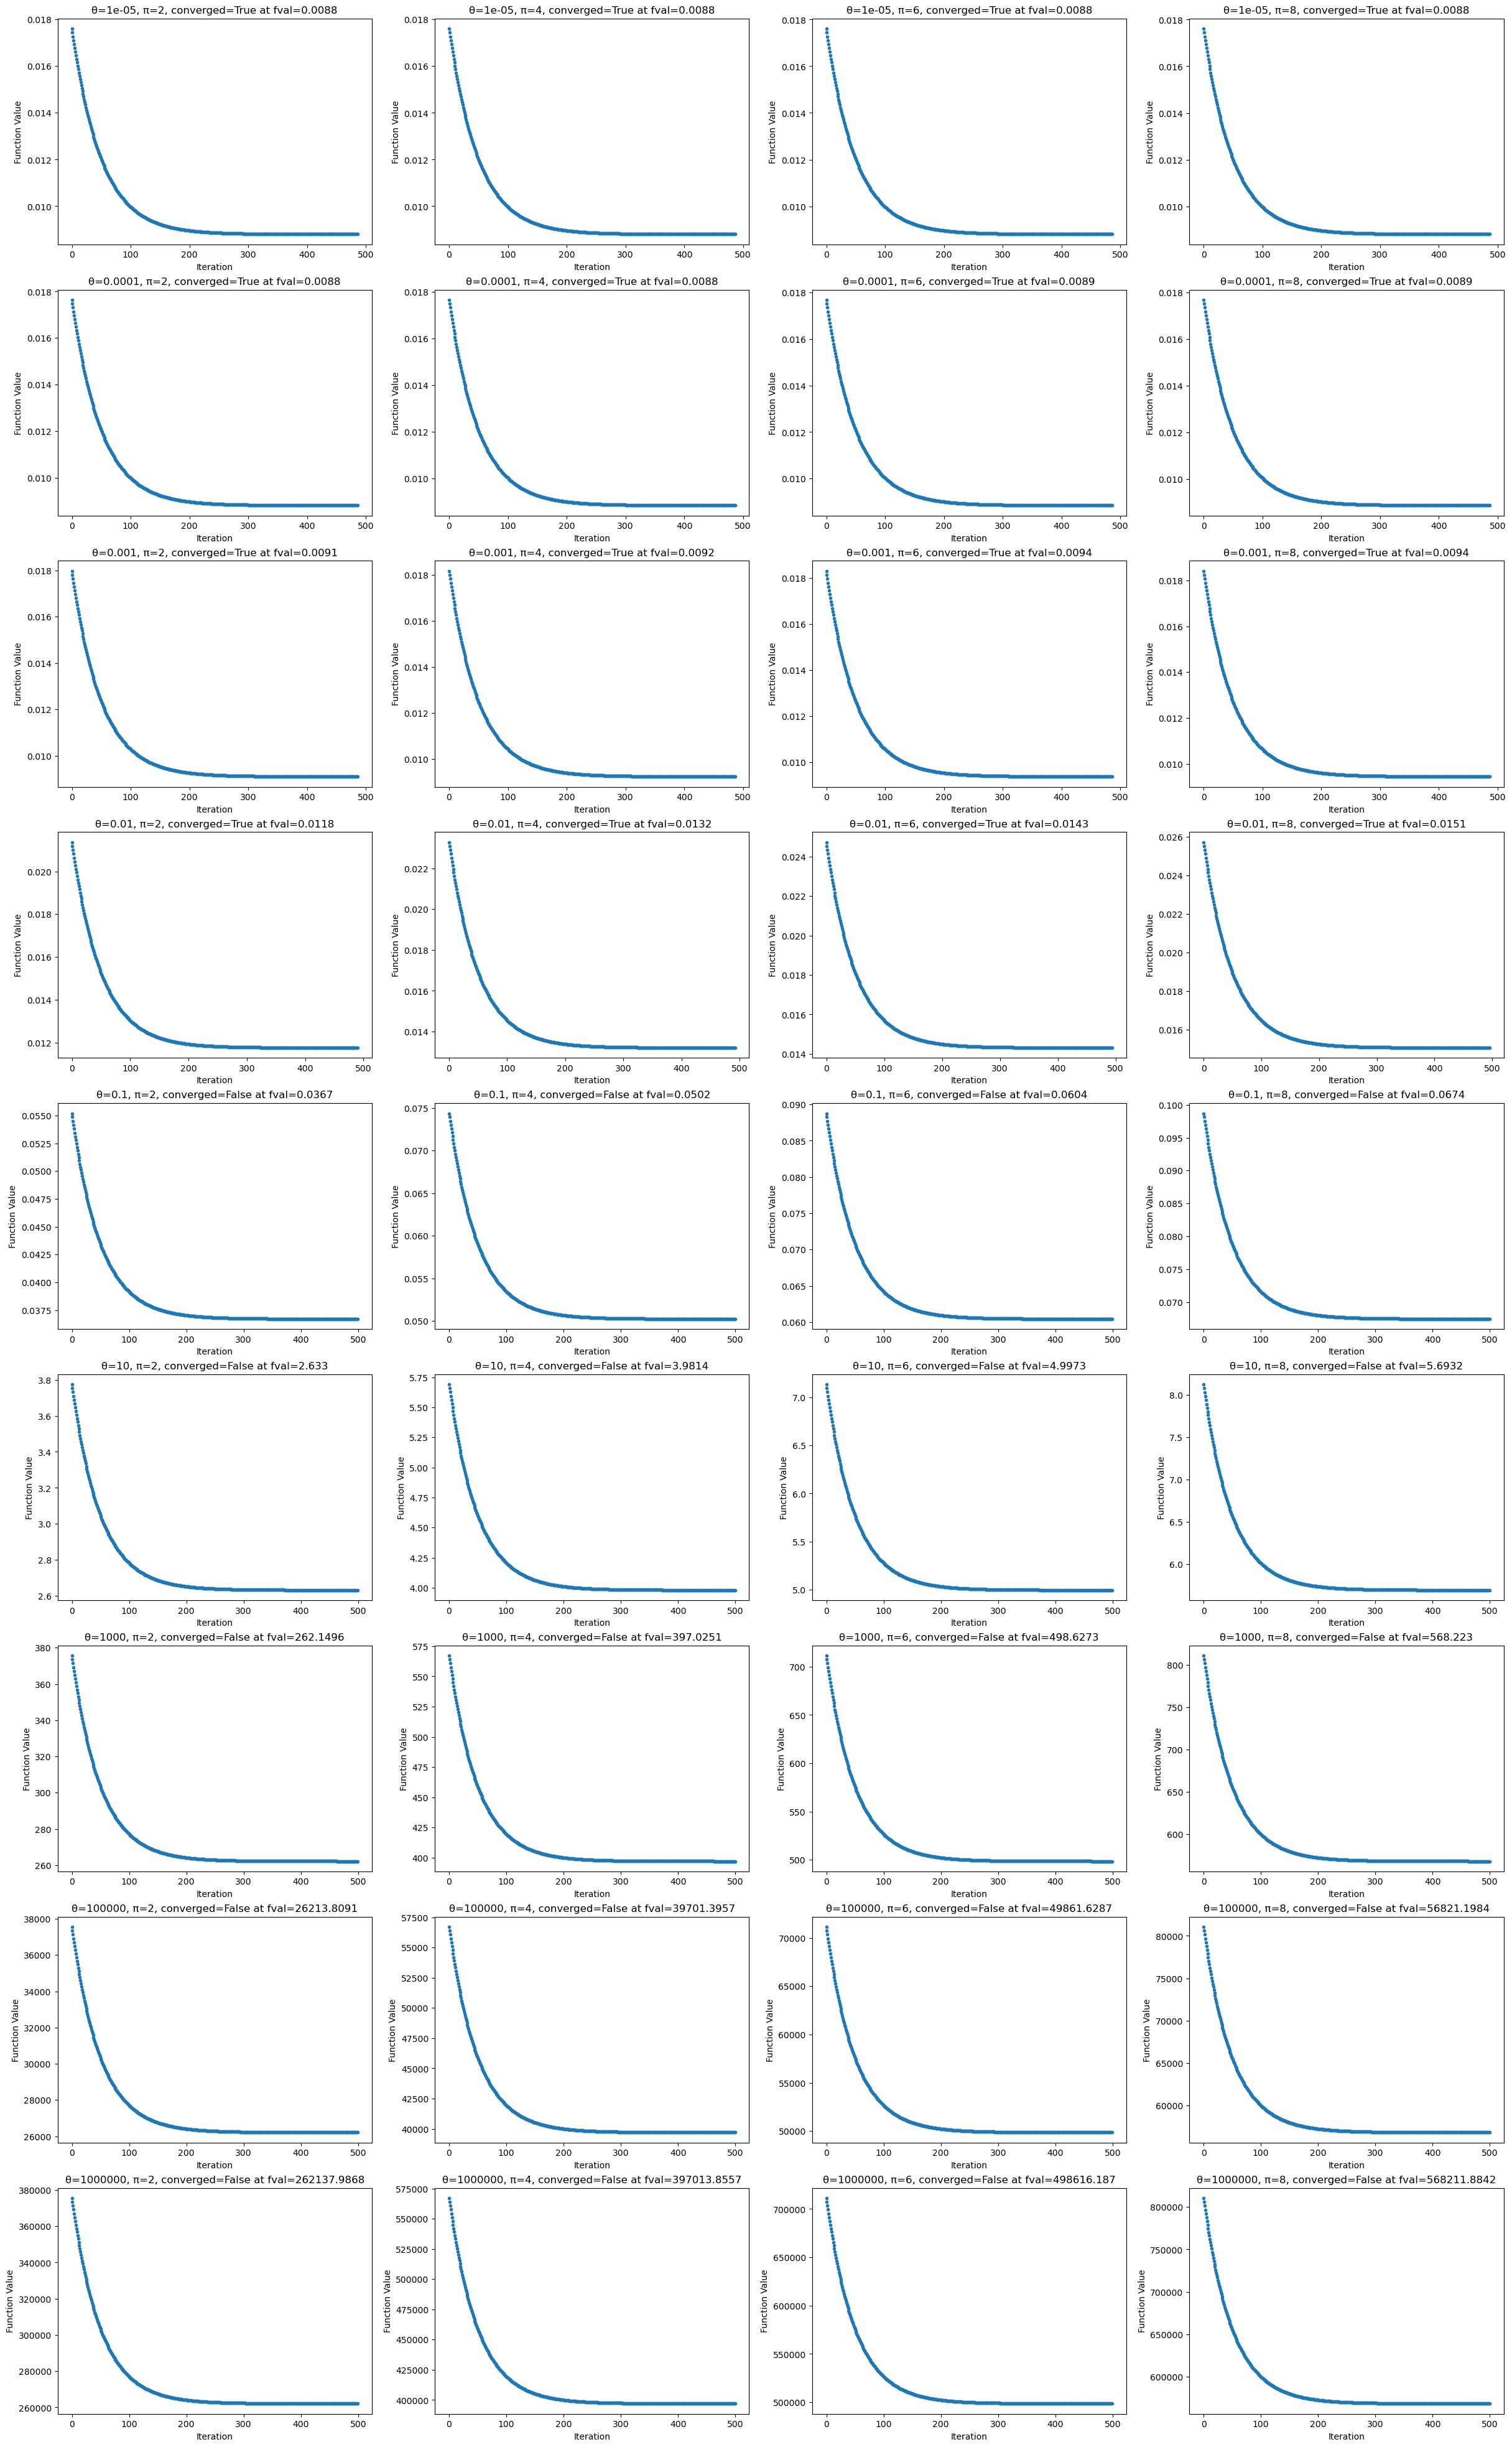

In [408]:
# initialize
x0, x1, x2 = 10,10,10

thetas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 1000, 10**5, 10**6]
T = 100
pis = [2, 4, 6, 8]
N = 500

rt0, rt1, rt2 = rt0[:T], rt1[:T], rt2[:T]
r0, r1, r2 = np.mean(rt0), np.mean(rt1), np.mean(rt2)

count = 0
results = {}

fig, axes = plt.subplots(len(thetas), len(pis), figsize=(30,50))
# count = 0
for i in range(len(thetas)):
    for j in range(len(pis)):
        x0sol = np.zeros(N)
        x1sol = np.zeros(N)
        x2sol = np.zeros(N)

        fvalsol = np.zeros(N)
        
        iteration, converged = run_grad_descent_momentum(x0, x1, x2, r0, r1, r2, thetas[i], T, pis[j], rt0, rt1, rt2, x0sol, x1sol, x2sol, fvalsol, N, 0.9, False, False)

        # if converged:
        #     count+=1
        #     # print("CONV")

        results[(thetas[i], pis[j])] = (x0sol[iteration],x1sol[iteration], x2sol[iteration])

        itr = i * len(pis) + j
        ax = axes[i, j]
        ax.scatter( np.arange(0,iteration+1) , fvalsol[:iteration+1], marker=".")
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Function Value')
        ax.set_title(f'\u03B8={thetas[i]}, \u03C0={pis[j]}, converged={converged} at fval={round(fvalsol[iteration],4)}')

# print(count)

In [409]:
for result in results:
    print(f"For theta={result[0]}, pi={result[1]}: x0={results[result][0]:.5f}, x1={results[result][1]:.5f}, x2={results[result][2]:.5f}")

For theta=1e-05, pi=2: x0=11.78015, x1=6.24905, x2=7.43012
For theta=1e-05, pi=4: x0=11.77998, x1=6.24907, x2=7.42997
For theta=1e-05, pi=6: x0=11.77984, x1=6.24911, x2=7.42984
For theta=1e-05, pi=8: x0=11.77975, x1=6.24916, x2=7.42971
For theta=0.0001, pi=2: x0=11.77692, x1=6.24961, x2=7.42730
For theta=0.0001, pi=4: x0=11.77518, x1=6.24986, x2=7.42586
For theta=0.0001, pi=6: x0=11.77384, x1=6.25025, x2=7.42447
For theta=0.0001, pi=8: x0=11.77293, x1=6.25072, x2=7.42323
For theta=0.001, pi=2: x0=11.74477, x1=6.25529, x2=7.39952
For theta=0.001, pi=4: x0=11.72770, x1=6.25794, x2=7.38554
For theta=0.001, pi=6: x0=11.71457, x1=6.26187, x2=7.37227
For theta=0.001, pi=8: x0=11.70566, x1=6.26662, x2=7.36042
For theta=0.01, pi=2: x0=11.44425, x1=6.31973, x2=7.15517
For theta=0.01, pi=4: x0=11.30109, x1=6.35096, x2=7.05583
For theta=0.01, pi=6: x0=11.19613, x1=6.39041, x2=6.96970
For theta=0.01, pi=8: x0=11.12697, x1=6.43387, x2=6.89629
For theta=0.1, pi=2: x0=9.88843, x1=6.93499, x2=6.27026


### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.

For theta=1e-05, pi=2 :
	 Returns made: 382049.7243, --> 0.0382%
For theta=1e-05, pi=4 :
	 Returns made: 382055.9978, --> 0.0382%
For theta=1e-05, pi=6 :
	 Returns made: 382063.5328, --> 0.0382%
For theta=1e-05, pi=8 :
	 Returns made: 382071.6784, --> 0.0382%
For theta=0.0001, pi=2 :
	 Returns made: 382178.0284, --> 0.0382%
For theta=0.0001, pi=4 :
	 Returns made: 382240.5357, --> 0.0382%
For theta=0.0001, pi=6 :
	 Returns made: 382315.5736, --> 0.0382%
For theta=0.0001, pi=8 :
	 Returns made: 382396.6867, --> 0.0382%
For theta=0.001, pi=2 :
	 Returns made: 383445.2824, --> 0.0383%
For theta=0.001, pi=4 :
	 Returns made: 384047.9705, --> 0.0384%
For theta=0.001, pi=6 :
	 Returns made: 384767.5526, --> 0.0385%
For theta=0.001, pi=8 :
	 Returns made: 385544.9438, --> 0.0386%
For theta=0.01, pi=2 :
	 Returns made: 394642.2774, --> 0.0395%
For theta=0.01, pi=4 :
	 Returns made: 398746.5283, --> 0.0399%
For theta=0.01, pi=6 :
	 Returns made: 403391.4511, --> 0.0403%
For theta=0.01, pi=8 :
	

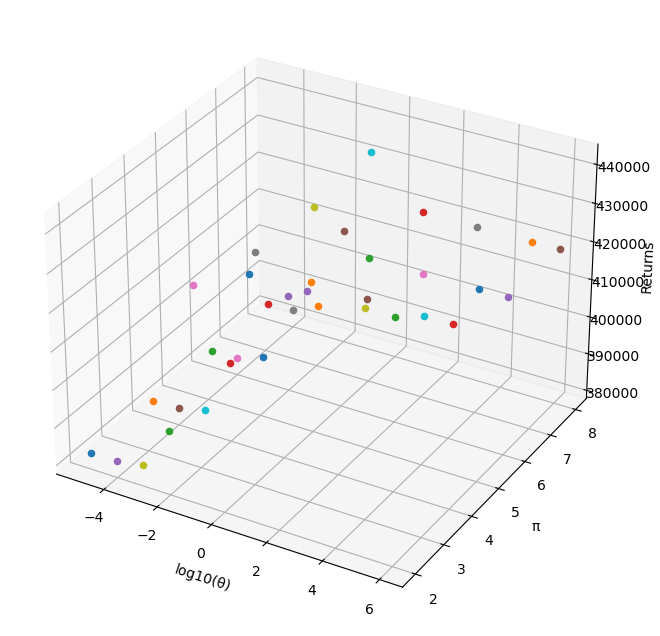

In [437]:
returns = pd.read_csv("./daily_returns_data/Returns.csv")
rt0, rt1, rt2 = returns['AMZN'].values, returns['NFLX'].values, returns['TSLA'].values

remaining_days0, remaining_days1, remaining_days2 = rt0[T:], rt1[T:], rt2[T:]
r0, r1, r2 = np.mean(remaining_days0), np.mean(remaining_days1), np.mean(remaining_days2)

returns_obt = {}

fig2 = plt.figure( figsize=(8,8))
ax = fig2.add_subplot(111, projection='3d')

for result in results:
    x0=results[result][0]
    x1=results[result][1]
    x2=results[result][2]
    
    total = x0 + x1 + x2
    scaled_x0 = x0/total
    scaled_x1 = x1/total
    scaled_x2 = x2/total

    avg_return = 10**9 *( r0*scaled_x0 + r1*scaled_x1 + r2*scaled_x2)

    returns_obt[(result[0], result[1])] = avg_return

    print(f"For theta={result[0]}, pi={result[1]} :")
    print(f"\t Returns made: {avg_return:.4f}, --> {avg_return/(1e7):.4f}%")

    ax.scatter(np.log10(result[0]), result[1], avg_return, marker='o')

    ax.set_xlabel('log10(\u03B8)')
    ax.set_ylabel('\u03C0')
    ax.set_zlabel('Returns')

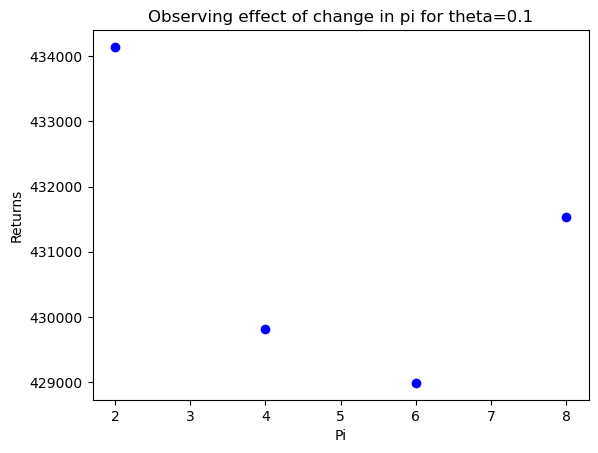

In [433]:
## Observing the change in returns due to change in pi for a fixed theta
## Fixing theta to 10

plt.figure()
plt.xlabel('Pi')
plt.ylabel('Returns')
plt.title('Observing effect of change in pi for theta=0.1')

for pi in pis:
    plt.scatter(pi , returns_obt[0.1, pi], color='blue', marker='o')


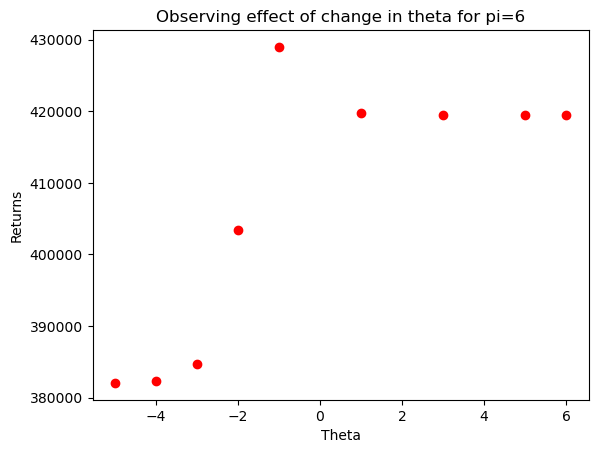

In [435]:
## Observing the change in returns due to change in theta for a fixed pi
## Fixing pi to 6

plt.figure()
plt.xlabel('Theta')
plt.ylabel('Returns')
plt.title('Observing effect of change in theta for pi=6')

for theta in thetas:
    plt.scatter(np.log10(theta), returns_obt[theta, 6], color='red', marker='o')
